# APPLYING WORD EMBEDDING TO IMDB RAW DATA

In [4]:
import os
imdb_dir = 'C:/Users/Student-PC/Downloads/aclImdb_v1/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [9]:
glove_dir = 'C:/Users/Student-PC/Downloads/archive'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [10]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [14]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 2s 10ms/sample - loss: 1.5786 - acc: 0.5850 - val_loss: 1.1582 - val_acc: 0.4915
Epoch 2/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.6299 - acc: 0.6700 - val_loss: 0.7177 - val_acc: 0.5389
Epoch 3/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.4309 - acc: 0.7750 - val_loss: 0.7144 - val_acc: 0.5432
Epoch 4/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.2245 - acc: 0.9650 - val_loss: 1.4433 - val_acc: 0.4917
Epoch 5/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.2916 - acc: 0.8900 - val_loss: 0.7336 - val_acc: 0.5497
Epoch 6/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.1194 - acc: 0.9900 - val_loss: 0.9699 - val_acc: 0.5115
Epoch 7/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.1111 - acc: 0.9850 - val_loss: 0.8256 - val_acc: 0.5397
Epoch 8/10
20

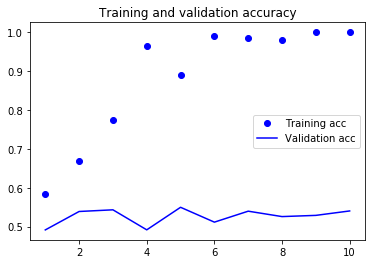

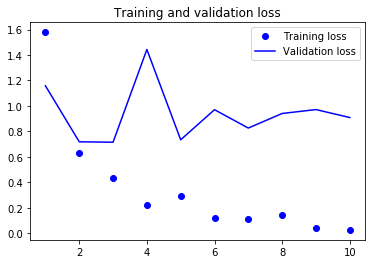

In [16]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [19]:
acc = np.asarray(acc)
val_acc = np.asarray(val_acc)
loss = np.asarray(loss)
val_loss = np.asarray(val_loss)

In [22]:
print("Avg Training Accuracy: ",round(acc.mean()*100,2))
print("Avg Validation Accuracy: ",round(val_acc.mean()*100,2))
print("Avg Training Loss: ",round(loss.mean()*100,2))
print("Avg Validation Loss: ", round(val_loss.mean()*100,2))

Avg Training Accuracy:  88.4
Avg Validation Accuracy:  52.61
Avg Training Loss:  35.9
Avg Validation Loss:  93.82


----------